In [2]:
# Libraries
from pathlib import Path
from matplotlib import pyplot as plt
from boutdata import collect
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from functools import reduce
from typing import *
import matplotlib
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
from collections import defaultdict
sns.set_style("whitegrid")

In [3]:
# Load and plot data

# Absolute path to either the BOUT output directory or an individual BOUT.dmp file.
DATA_LOCATION = Path(
	r"data/BOUT.dmp.0.nc"
 )


def load_density(path_hint: Path):
	"""Return the density field collected from BOUT output files."""
	path_hint = path_hint.expanduser().resolve()

	# If the user points at a single file we only need the parent directory.
	bout_dir = path_hint.parent if path_hint.is_file() else path_hint

	data = collect("n", path=str(bout_dir))
	return data.squeeze()


def plot_timestep(density,idx,vert=(False, None)):
	"""Plot the density at the final time step."""
	fig, ax = plt.subplots()
	contour = ax.contourf(density[idx, :, :].T)
	fig.colorbar(contour, ax=ax, label="n (arb. units)")
	ax.set_title("Density at final timestep")
	ax.set_xlabel("x index")
	ax.set_ylabel("z index")
	if vert[0] == True:
		ax.vlines(vert[1], 0, 1023)
	plt.show()

density_data = load_density(DATA_LOCATION)


mxsub = 8 mysub = 1 mz = 1024

nxpe = 128, nype = 1, npes = 128

Reading from 0: [0-9][0-0] -> [0-9][0-0]

Reading from 1: [2-9][0-0] -> [10-17][0-0]

Reading from 2: [2-9][0-0] -> [18-25][0-0]

Reading from 3: [2-9][0-0] -> [26-33][0-0]

Reading from 4: [2-9][0-0] -> [34-41][0-0]

Reading from 5: [2-9][0-0] -> [42-49][0-0]

Reading from 6: [2-9][0-0] -> [50-57][0-0]

Reading from 7: [2-9][0-0] -> [58-65][0-0]

Reading from 8: [2-9][0-0] -> [66-73][0-0]

Reading from 9: [2-9][0-0] -> [74-81][0-0]

Reading from 10: [2-9][0-0] -> [82-89][0-0]

Reading from 11: [2-9][0-0] -> [90-97][0-0]

Reading from 12: [2-9][0-0] -> [98-105][0-0]

Reading from 13: [2-9][0-0] -> [106-113][0-0]

Reading from 14: [2-9][0-0] -> [114-121][0-0]

Reading from 15: [2-9][0-0] -> [122-129][0-0]

Reading from 16: [2-9][0-0] -> [130-137][0-0]

Reading from 17: [2-9][0-0] -> [138-145][0-0]

Reading from 18: [2-9][0-0] -> [146-153][0-0]

Reading from 19: [2-9][0-0] -> [154-161][0-0]

Reading from 20: [2-9][0-0] -> [

### Data Info

- 128 images of the nHESEL simulation
- Width = 1024, Height = 1028

In [4]:
print(density_data[0, :, :].shape)

(1028, 1024)


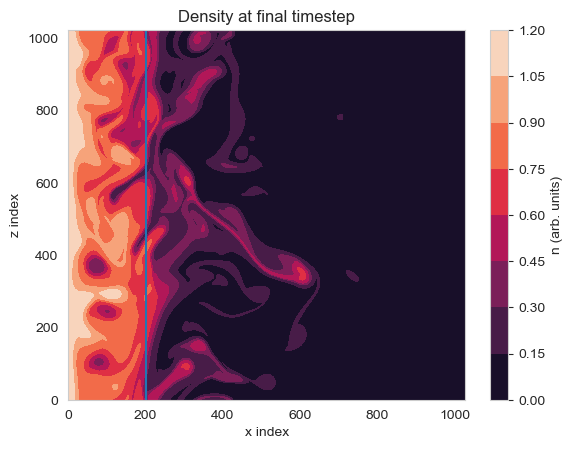

In [5]:
plot_timestep(density_data, idx=89, vert=(True, 200))

# It seems to be fitting to have the edge of the man plasma at x = 200

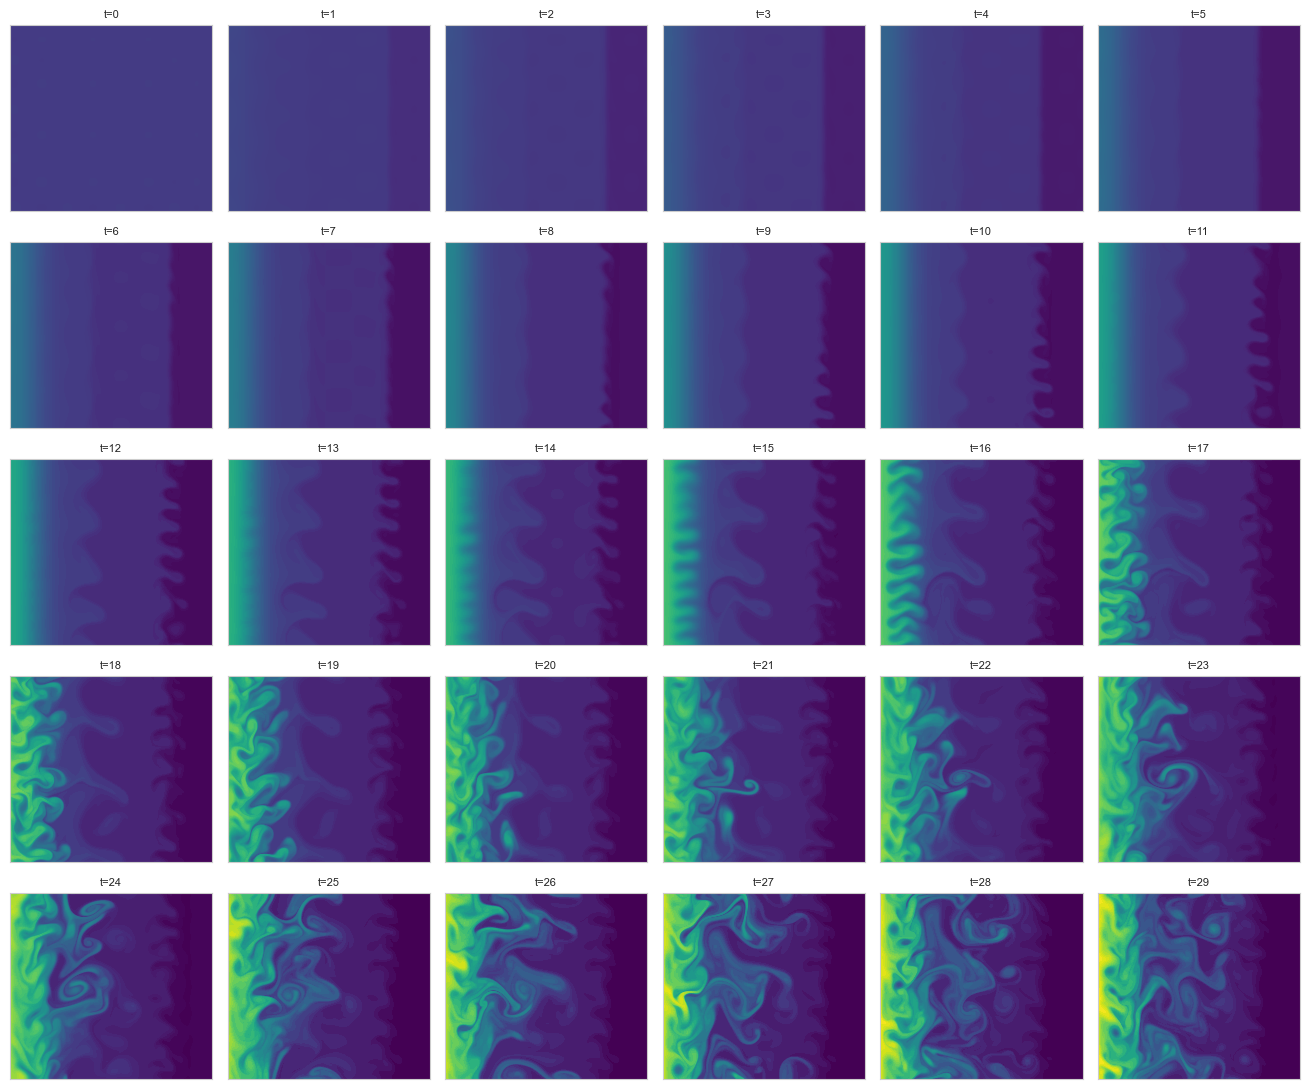

In [6]:
# Plot first 30 timesteps in a 5x6 grid
import numpy as np

n_plots = 30
rows, cols = 5, 6

# Use the loaded density data
data = density_data

# Compute consistent color scale across all frames
vmin = float(np.min(data[:n_plots]))
vmax = float(np.max(data[:n_plots]))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
for idx, ax in enumerate(axes.flat):
    im = ax.contourf(data[idx, :, :].T, levels=50, vmin=vmin, vmax=vmax, cmap="viridis")
    ax.set_title(f"t={idx}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

# Single colorbar for the whole figure
plt.tight_layout()
plt.show()

# The simulation first seems to have converged at approximately 28 steps into the simulation


## VAE

In [7]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        epsilon = self.sample_epsilon()
        return self.mu + self.sigma * epsilon
            
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return -0.5 * (math.log(2 * math.pi) + 2 * torch.log(self.sigma) + ((z - self.mu) ** 2) / (self.sigma ** 2))




In [20]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first forward pass."""
    
    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class ConvolutionalVariationalAutoencoder(nn.Module):
    def __init__(self, input_shape:torch.Size, latent_features: int, in_channels: int = 1) -> None:
        super().__init__()
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.in_channels = in_channels
        
        # Convolutional encoder keeps the code compact while extracting spatial features.
        self.conv_encoder = nn.Sequential(
            PrintSize(),
            nn.Conv2d(in_channels, 32, kernel_size=128, stride=4, padding=(0,2)), # Output 226x226
            PrintSize(),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=30, stride=6, padding=1), # Output dim: 34x34
            PrintSize(),
            nn.ReLU(),
            nn.Dropout(),
            nn.Flatten(),
            PrintSize(),
            nn.ReLU(),
            nn.Linear(16*34*34,256),
            nn.Flatten(),
            PrintSize(),
            nn.ReLU(),
            nn.Linear(256,latent_features*2) # Notice that we multiply with 2 (sigma, mu)
        )
                
                
        self.conv_decoder = nn.Sequential(
            nn.Linear(latent_features, 256),
            nn.ReLU(),
            nn.Linear(256, 34*34*16),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(16, 34, 34)),
            nn.ConvTranspose2d(in_channels=16, 
                               out_channels=32, 
                               kernel_size=30,
                               stride=6,
                               padding=1,
            ),
            nn.ReLU(),
            PrintSize(),
            nn.ConvTranspose2d(in_channels=32,
                               out_channels=in_channels,
                               kernel_size=128,
                               stride=4,
                               padding=(0, 2)
            ),
            PrintSize()
        )
        
        # Prior parameters stay identical to the dense version.
        self.register_buffer("prior_params", torch.zeros(1, 2 * latent_features))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.conv_encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.conv_decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        return Bernoulli(logits=px_logits, validate_args=False)
        
    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
        
    def sample_from_prior(self, batch_size: int = 16) -> Dict[str, Any]:
        pz = self.prior(batch_size=batch_size)
        z = pz.rsample()
        px = self.observation_model(z)
        return {"px": px, "pz": pz, "z": z}


latent_features = 2
# Example usage once you have tensors shaped as (batch, 1, H, W):
# print(sum(p.numel() for p in vae.parameters())/1e6, "M parameters")

In [18]:
print(density_data[:,:,:].shape)
test = torch.tensor(density_data[0,:,:], dtype=torch.float32)
print(test.shape)
test = test.unsqueeze(0).unsqueeze(0)
print(test.shape)

(93, 1028, 1024)
torch.Size([1028, 1024])
torch.Size([1, 1, 1028, 1024])


In [21]:
# Testing if valid dimensions in Convolutional VAE
dummy_tensor = test
#dummy_tensor = torch.tensor(density_data[0,:,:,:].reshape(1,1028,1024), dtype=torch.float32)
C_VAE = ConvolutionalVariationalAutoencoder(dummy_tensor.shape, latent_features)
# Going manually through the the forward() method

# define the posterior q(z|x) / encode x into q(z|x)
qz = C_VAE.posterior(dummy_tensor)

# define the prior p(z)
pz = C_VAE.prior(batch_size=dummy_tensor.size(0))

# sample the posterior using the reparameterization trick: z ~ q(z | x)
z = qz.rsample()

# define the observation model p(x|z) = B(x | g(z))
px = C_VAE.observation_model(z)

Size: torch.Size([1, 1, 1028, 1024])
Size: torch.Size([1, 32, 226, 226])
Size: torch.Size([1, 16, 34, 34])
Size: torch.Size([1, 18496])
Size: torch.Size([1, 256])
Size: torch.Size([1, 32, 226, 226])
Size: torch.Size([1, 1, 1028, 1024])


In [11]:
latent_features = 2
VAE = VariationalAutoencoder(density_data_tesnor[0].shape,latent_features)
print(VAE)

NameError: name 'VariationalAutoencoder' is not defined